## Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

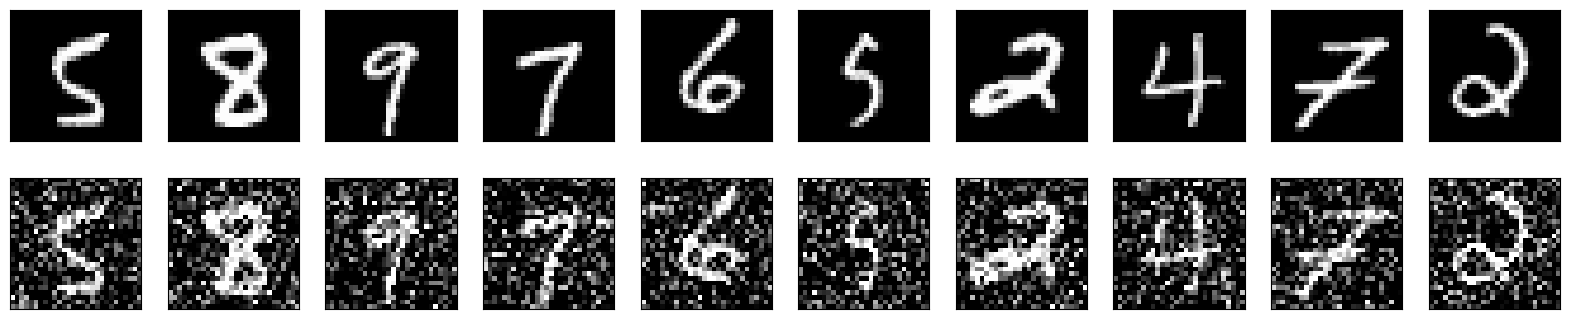

In [9]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [10]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 32)        9248

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [11]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 9s 12ms/step - loss: 0.1329 - val_loss: 0.0735
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0717 - val_loss: 0.0695
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0693 - val_loss: 0.0681
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0681 - val_loss: 0.0671
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0674 - val_loss: 0.0665
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0668 - val_loss: 0.0660
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0659 - val_loss: 0.0653
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0653 - val_loss: 0.0

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 [==============================] - 1s 2ms/step


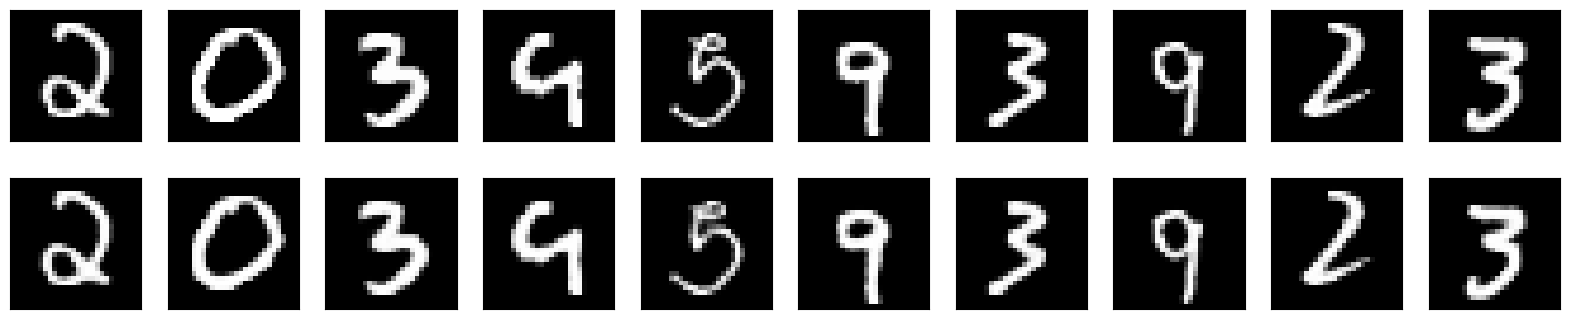

In [12]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [13]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1012 - val_loss: 0.0933
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0929 - val_loss: 0.0912
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0913 - val_loss: 0.0900
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0904 - val_loss: 0.0892
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0897 - val_loss: 0.0887
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0891 - val_loss: 0.0883
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0887 - val_loss: 0.0879
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0884 - val_loss: 0.0878
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0881 - val_loss: 0.0873
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0878 - val_lo

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 [==============================] - 1s 2ms/step


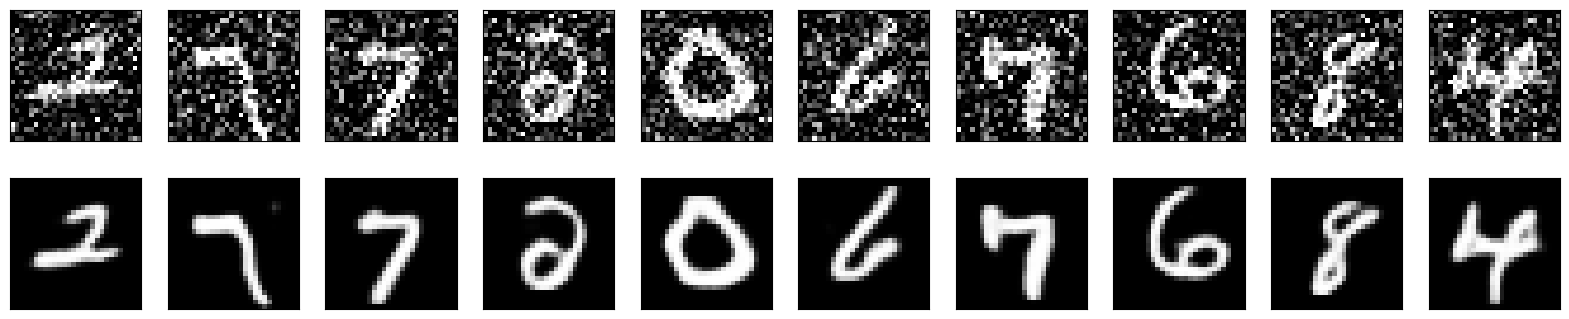

In [14]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)